In [1]:
# Import libraries
import os
import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Define get features function

def get_features(data_path, target_length=None, smoothing_method=None, feature_type=None):
    features = []
    labels = []
    
    session_labels = {
    '1': [1,2,3,0,2,0,0,1,0,1,2,1,1,1,2,3,2,2,3,3,0,3,0,3],
    '2': [2,1,3,0,0,2,0,2,3,3,2,3,2,0,1,1,2,1,0,3,0,1,3,1],
    '3': [1,2,2,1,3,3,3,1,1,2,1,0,2,3,3,0,2,3,0,0,2,0,1,0]
    }
    
    for session_folder in ['1', '2', '3']:
        session_path = os.path.join(data_path, session_folder)
    
        for file_name in os.listdir(session_path):
            if file_name.endswith('.mat'):
                file_path = os.path.join(session_path, file_name)
                mat = loadmat(file_path)
                
                for trial_num in range(1, 25):
                    label_idx = trial_num - 1
                    emotion_label = session_labels[session_folder][label_idx]
                    
                    psd_key = f'psd_{smoothing_method}{trial_num}'
                    de_key = f'de_{smoothing_method}{trial_num}'
                    
                    if psd_key in mat and de_key in mat:
                        psd_data = mat[psd_key]
                        de_data = mat[de_key]
                        feature_data = de_data
                        if feature_type == 'de': 
                            feature_data = de_data
                        else:
                            feature_data = psd_data

                        # Padding/Truncating
                        if target_length is not None:
                            current_length = feature_data.shape[1]
                            if current_length < target_length:
                                pad_width = target_length - current_length
                                padding = np.zeros((62, pad_width, 5))
                                feature_data = np.concatenate((feature_data, padding), axis=1)
                            elif current_length > target_length:
                                feature_data = feature_data[:, :target_length, :]

                        features.append(feature_data)
                        labels.append(emotion_label)

    return np.array(features), np.array(labels)

In [4]:
# All data processing

# Setup
data_path = 'eeg_feature_smooth'
feature_type = 'de' # Or 'psd'
smoothing_method = 'LDS' # Or 'movingAve'

# Get the maximum length of time windows
max_length = 0
for session_folder in ['1', '2', '3']:
    session_path = os.path.join(data_path, session_folder)
    for file_name in os.listdir(session_path):
        if file_name.endswith('.mat'):
            file_path = os.path.join(session_path, file_name)
            mat = loadmat(file_path)
            for trial_num in range(1, 25):
                psd_key = f'psd_{smoothing_method}{trial_num}'
                de_key = f'de_{smoothing_method}{trial_num}'
                if psd_key in mat and de_key in mat:
                    if feature_type == 'de': 
                        de_data = mat[de_key]
                        max_length = max(max_length, de_data.shape[1])
                    else:
                        psd_data = mat[psd_key]
                        max_length = max(max_length, psd_data.shape[1])

# Get features and label
features, labels = get_features(data_path, target_length=max_length, smoothing_method=smoothing_method, feature_type=feature_type)

# Reshape data
num_samples, num_channels, target_length, num_bands = features.shape
features = features.reshape(num_samples, num_channels * target_length * num_bands)

# Split data
# Choose how to split data
split_type = 'imbalance' # or whatever
if split_type != 'balance':
    # Labels imbalance
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
else:
    # Labels balance
    X = features
    y = labels
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in splitter.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Check data shape
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)
print("Train set shape", X_train.shape)
print("Test set shape", X_test.shape)

Features shape: (1080, 19840)
Labels shape: (1080,)
Train set shape (864, 19840)
Test set shape (216, 19840)


In [5]:
# Just for checking when choose how to split data
def label_count(data, data_name):
    unique_labels, counts = np.unique(data, return_counts=True)
    print(f"Label counts for {data_name}:")
    for label, count in zip(unique_labels, counts):
        print(f"{label}: {count} samples")
    
label_count(labels, 'all labels')
print("------------------------------")
label_count(y_train, 'train labels')
print("------------------------------")
label_count(y_test, 'test labels')


Label counts for all labels:
0: 270 samples
1: 270 samples
2: 270 samples
3: 270 samples
------------------------------
Label counts for train labels:
0: 225 samples
1: 220 samples
2: 205 samples
3: 214 samples
------------------------------
Label counts for test labels:
0: 45 samples
1: 50 samples
2: 65 samples
3: 56 samples


In [6]:
# PCA if needed
pca = PCA(n_components=0.999)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("Train set shape", X_train_pca.shape)
print("Test set shape", X_test_pca.shape)

Train set shape (864, 163)
Test set shape (216, 163)


In [7]:
# For Confusion Matrix
emotion_labels = {
    0: '0. neutral',
    1: '1. sad',
    2: '2. fear',
    3: '3. happy'
}

Accuracy: 0.7962962962962963
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.80      0.75        45
           1       0.80      0.72      0.76        50
           2       0.78      0.77      0.78        65
           3       0.89      0.89      0.89        56

    accuracy                           0.80       216
   macro avg       0.79      0.80      0.79       216
weighted avg       0.80      0.80      0.80       216



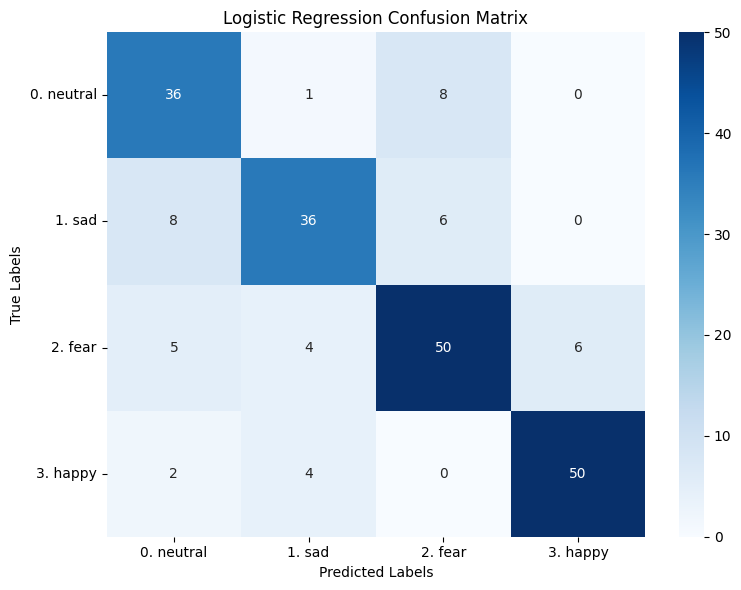

In [8]:
# Logistic Regression model
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

lr_accuracy = accuracy_score(y_test, lr_pred)
lr_report = classification_report(y_test, lr_pred)
lr_confusion = confusion_matrix(y_test, lr_pred)

print(f"Accuracy: {lr_accuracy}")
print("Classification Report:\n", lr_report)

plt.figure(figsize=(8,6))
sns.heatmap(lr_confusion, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

SVM Accuracy: 0.7824074074074074
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.87      0.74        45
           1       0.79      0.76      0.78        50
           2       0.82      0.69      0.75        65
           3       0.89      0.84      0.86        56

    accuracy                           0.78       216
   macro avg       0.79      0.79      0.78       216
weighted avg       0.79      0.78      0.78       216



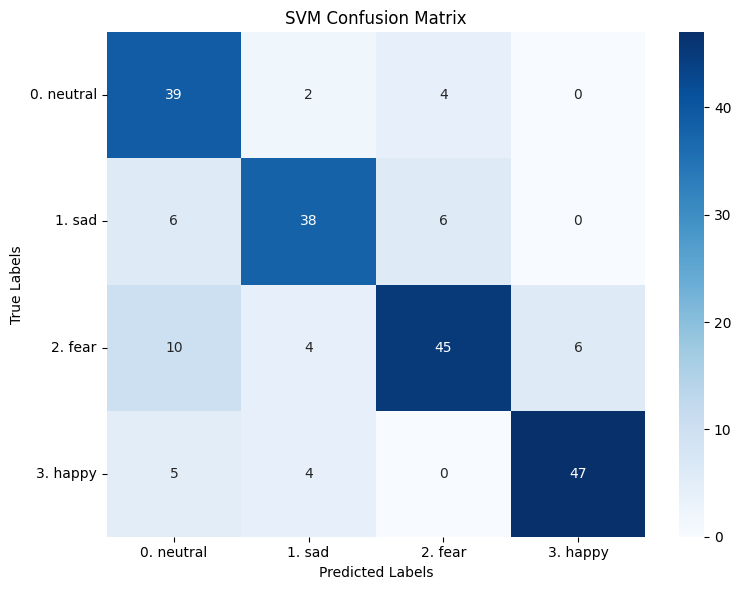

In [9]:
# SVM model
svm_model = SVC(kernel='linear', C=1, gamma='scale', class_weight='balanced')
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

svm_accuracy = accuracy_score(y_test, svm_pred)
svm_report = classification_report(y_test, svm_pred)
svm_confusion = confusion_matrix(y_test, svm_pred)

print(f"SVM Accuracy: {svm_accuracy}")
print("SVM Classification Report:\n", svm_report)

plt.figure(figsize=(8,6))
sns.heatmap(svm_confusion, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Random Forest Accuracy: 0.6712962962962963
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.76      0.61        45
           1       0.67      0.62      0.65        50
           2       0.78      0.55      0.65        65
           3       0.76      0.79      0.77        56

    accuracy                           0.67       216
   macro avg       0.68      0.68      0.67       216
weighted avg       0.70      0.67      0.67       216



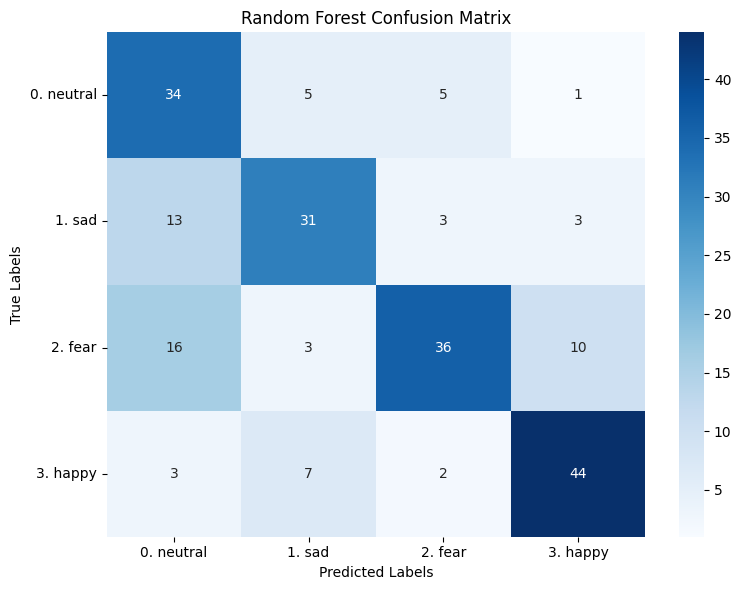

In [20]:
# Random Forest model
rf_model = RandomForestClassifier(random_state=69, n_estimators=300)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_pred)
rf_report = classification_report(y_test, rf_pred)
rf_confusion = confusion_matrix(y_test, rf_pred)

print(f"Random Forest Accuracy: {rf_accuracy}")
print("Random Forest Classification Report:\n", rf_report)

plt.figure(figsize=(8,6))
sns.heatmap(rf_confusion, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Accuracy: 0.6851851851851852
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.67      0.58        45
           1       0.70      0.76      0.73        50
           2       0.73      0.54      0.62        65
           3       0.80      0.80      0.80        56

    accuracy                           0.69       216
   macro avg       0.69      0.69      0.68       216
weighted avg       0.70      0.69      0.69       216



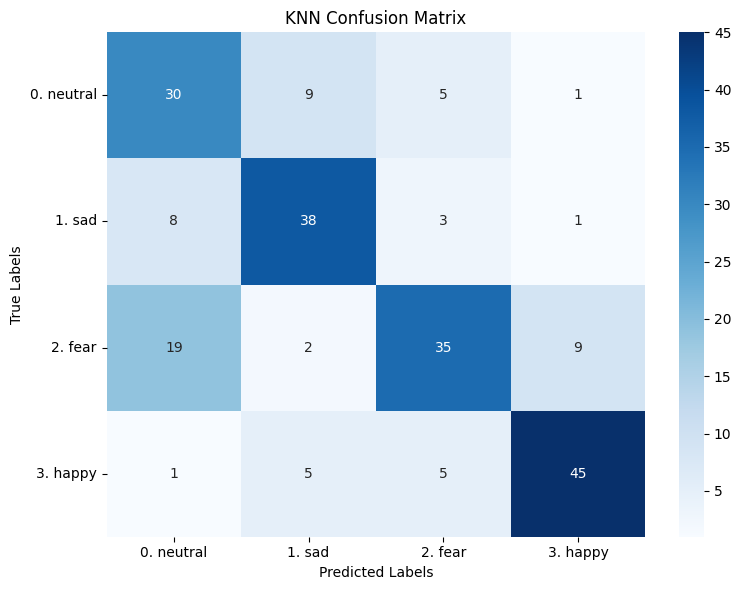

In [56]:
from sklearn.neighbors import KNeighborsClassifier

# KNN model
knn_model = KNeighborsClassifier(n_neighbors=16)
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)

knn_accuracy = accuracy_score(y_test, knn_pred)
knn_report = classification_report(y_test, knn_pred)
knn_confusion = confusion_matrix(y_test, knn_pred)

print(f"Accuracy: {knn_accuracy}")
print("Classification Report:\n", knn_report)

plt.figure(figsize=(8, 6))
sns.heatmap(knn_confusion, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [65]:
# All data processing

# Setup
data_path = 'eeg_feature_smooth'
feature_type = 'psd' # Or 'de'
smoothing_method = 'movingAve' # Or 'LDS'

# Get the maximum length of time windows
max_length = 0
for session_folder in ['1', '2', '3']:
    session_path = os.path.join(data_path, session_folder)
    for file_name in os.listdir(session_path):
        if file_name.endswith('.mat'):
            file_path = os.path.join(session_path, file_name)
            mat = loadmat(file_path)
            for trial_num in range(1, 25):
                psd_key = f'psd_{smoothing_method}{trial_num}'
                de_key = f'de_{smoothing_method}{trial_num}'
                if psd_key in mat and de_key in mat:
                    if feature_type == 'de': 
                        de_data = mat[de_key]
                        max_length = max(max_length, de_data.shape[1])
                    else:
                        psd_data = mat[psd_key]
                        max_length = max(max_length, psd_data.shape[1])

# Get features and label
features, labels = get_features(data_path, target_length=max_length, smoothing_method=smoothing_method, feature_type=feature_type)

# Reshape data
num_samples, num_channels, target_length, num_bands = features.shape
features = features.reshape(num_samples, num_channels * target_length * num_bands)

# Split data
# Choose how to split data
split_type = 'imbalance' # or whatever
if split_type != 'balance':
    # Labels imbalance
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
else:
    # Labels balance
    X = features
    y = labels
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in splitter.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Check data shape
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)
print("Train set shape", X_train.shape)
print("Test set shape", X_test.shape)

Features shape: (1080, 19840)
Labels shape: (1080,)
Train set shape (864, 19840)
Test set shape (216, 19840)


Random Forest Accuracy: 0.7037037037037037
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.78      0.65        45
           1       0.71      0.70      0.71        50
           2       0.82      0.55      0.66        65
           3       0.77      0.82      0.79        56

    accuracy                           0.70       216
   macro avg       0.71      0.71      0.70       216
weighted avg       0.73      0.70      0.70       216



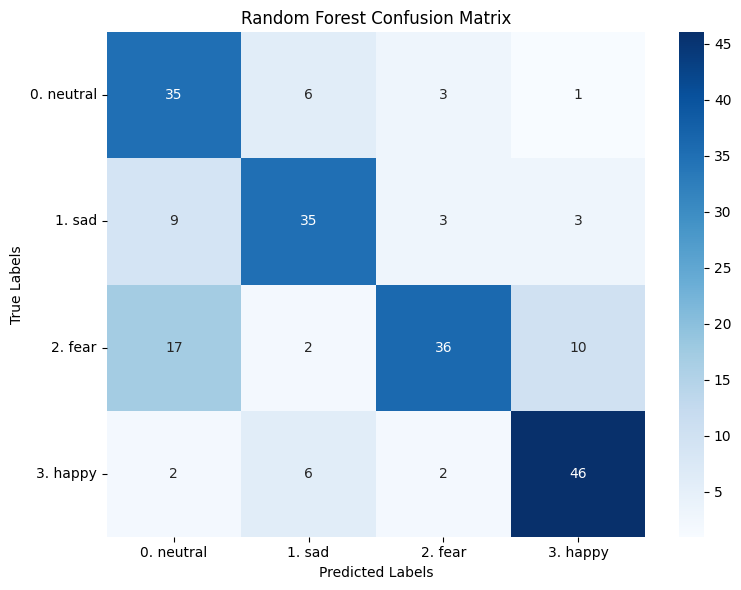

In [75]:
# Random Forest model
rf_model = RandomForestClassifier(random_state=18, n_estimators=200)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_pred)
rf_report = classification_report(y_test, rf_pred)
rf_confusion = confusion_matrix(y_test, rf_pred)

print(f"Random Forest Accuracy: {rf_accuracy}")
print("Random Forest Classification Report:\n", rf_report)

plt.figure(figsize=(8,6))
sns.heatmap(rf_confusion, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
#kernal linear c1 gamma scale 51acc
#kernal linear c0.1 gamma scale 48acc
#kernal linear c10 gamma scale 53acc
#kernal linear c10 gamma 0.1 53acc
#kernal linear c10 gamma 1 53acc

In [29]:
param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

rf_model = RandomForestClassifier(random_state=42)
grid = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

best_params = grid.best_params_
best_rf = grid.best_estimator_

print(f"Best parameters: {best_params}")

y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print(f"Accuracy on test set: {accuracy}")
print("Classification Report:\n", report)
print("Confusion Matrix:\n", confusion)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters: {'class_weight': None, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy on test set: 0.6712962962962963
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.82      0.65        45
           1       0.71      0.58      0.64        50
           2       0.74      0.52      0.61        65
           3       0.74      0.80      0.77        56

    accuracy                           0.67       216
   macro avg       0.68      0.68      0.67       216
weighted avg       0.69      0.67      0.67       216

Confusion Matrix:
 [[37  3  4  1]
 [13 29  5  3]
 [16  3 34 12]
 [ 2  6  3 45]]
